## Two qubits' example (one marked state) 

In [1]:
#initialization

import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

In [2]:
# prepare a quantum circuit with 2 qubits 

n = 2
grover_circuit = QuantumCircuit(n)

In [3]:
# step 1 (a superpostions for all qubits)

def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in the circuit"""
    for q in qubits:
        qc.h(q)
    return qc

In [4]:
grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘

In [5]:
# apply oracle function

grover_circuit.cz(0,1) # Oracle
grover_circuit.draw()

┌───┐   
q_0: ┤ H ├─■─
     ├───┤ │ 
q_1: ┤ H ├─■─
     └───┘

In [6]:
# amplification step (after one iteration)
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1) # H-CNOT-H
grover_circuit.h([0,1])
grover_circuit.draw()

┌───┐   ┌───┐┌───┐   ┌───┐
q_0: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     ├───┤ │ ├───┤├───┤ │ ├───┤
q_1: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     └───┘   └───┘└───┘   └───┘

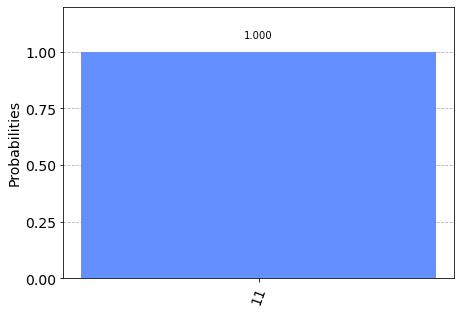

In [7]:
# run on simulations 

grover_circuit.measure_all()

aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(grover_circuit)
result = aer_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

We can't run the circuit a real device because we don't have access to a IBM account 

## Four qubits' example (one marked state) 

In [8]:
def new_initialize_s(qc, qubits):
    """Apply a X-gate and H-gate to 'qubits' in the circuit"""
    for q in qubits:
        qc.x(q)
        qc.h(q)
    return qc

In [9]:
# build oracle function |1101>

qc = QuantumCircuit(4)
qc.x(1)
qc.h(3)
qc.mct(list(range(3)), 3)  # multi-controlled-toffoli
qc.h(3)
qc.x(1)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"


In [10]:
# build diffuser 

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [11]:
n=4
grover_circuit = QuantumCircuit(n)
grover_circuit = new_initialize_s(grover_circuit, [0,1,2,3])

# first iteration 
grover_circuit.append(oracle_ex3, [0,1,2,3])
grover_circuit.append(diffuser(n), [0,1,2,3])
grover_circuit.measure_all()
grover_circuit.draw()

┌───┐┌───┐┌─────────────┐┌────────┐ ░ ┌─┐         
   q_0: ┤ X ├┤ H ├┤0            ├┤0       ├─░─┤M├─────────
        ├───┤├───┤│             ││        │ ░ └╥┘┌─┐      
   q_1: ┤ X ├┤ H ├┤1            ├┤1       ├─░──╫─┤M├──────
        ├───┤├───┤│  U$_\omega$ ││  U$_s$ │ ░  ║ └╥┘┌─┐   
   q_2: ┤ X ├┤ H ├┤2            ├┤2       ├─░──╫──╫─┤M├───
        ├───┤├───┤│             ││        │ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ X ├┤ H ├┤3            ├┤3       ├─░──╫──╫──╫─┤M├
        └───┘└───┘└─────────────┘└────────┘ ░  ║  ║  ║ └╥┘
meas: 4/═══════════════════════════════════════╩══╩══╩══╩═
                                               0  1  2  3

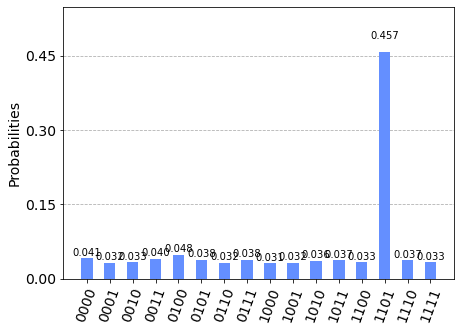

In [12]:
# experiment with simulator (with one iteration)

aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [13]:
# optimal numbers of iterations (3 times?)

n=4
grover_circuit = QuantumCircuit(n)
grover_circuit = new_initialize_s(grover_circuit, [0,1,2,3])

counter = 0

while counter < 3:
    grover_circuit.append(oracle_ex3, [0,1,2,3])
    grover_circuit.append(diffuser(n), [0,1,2,3])
    counter += 1

if counter == 3:
    print ("iteration completed")

grover_circuit.measure_all()
grover_circuit.draw()

iteration completed


┌───┐┌───┐┌─────────────┐┌────────┐┌─────────────┐┌────────┐»
   q_0: ┤ X ├┤ H ├┤0            ├┤0       ├┤0            ├┤0       ├»
        ├───┤├───┤│             ││        ││             ││        │»
   q_1: ┤ X ├┤ H ├┤1            ├┤1       ├┤1            ├┤1       ├»
        ├───┤├───┤│  U$_\omega$ ││  U$_s$ ││  U$_\omega$ ││  U$_s$ │»
   q_2: ┤ X ├┤ H ├┤2            ├┤2       ├┤2            ├┤2       ├»
        ├───┤├───┤│             ││        ││             ││        │»
   q_3: ┤ X ├┤ H ├┤3            ├┤3       ├┤3            ├┤3       ├»
        └───┘└───┘└─────────────┘└────────┘└─────────────┘└────────┘»
meas: 4/════════════════════════════════════════════════════════════»
                                                                    »
«        ┌─────────────┐┌────────┐ ░ ┌─┐         
«   q_0: ┤0            ├┤0       ├─░─┤M├─────────
«        │             ││        │ ░ └╥┘┌─┐      
«   q_1: ┤1            ├┤1       ├─░──╫─┤M├──────
«        │  U$_\omega$ ││  U$_s$ │ ░  ║ └╥┘┌─┐   
«   q_2: ┤2            ├┤2       ├─░──╫──╫─┤M├───
«        │             ││        │ ░  ║  ║ └╥┘┌─┐
«   q_3: ┤3            ├┤3       ├─░──╫──╫──╫─┤M├
«        └─────────────┘└────────┘ ░  ║  ║  ║ └╥┘
«meas: 4/═════════════════════════════╩══╩══╩══╩═
«                                     0  1  2  3

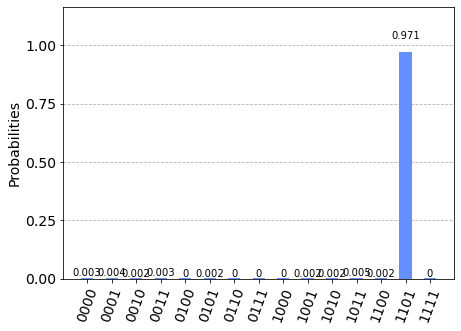

In [14]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

## Four qubits' example (two marked state) 

In [27]:
n=4
grover_circuit = QuantumCircuit(n)
grover_circuit = new_initialize_s(grover_circuit, [0,1,2,3])

counter = 0
iteration = 2

# build oracle functions |1100> and |1110>

# for |1100>
qc = QuantumCircuit(4)
qc.x(0)
qc.x(1)
# CZ gates for 4 qubits 
qc.h(3)
qc.mct(list(range(3)), 3)  # multi-controlled-toffoli
qc.h(3)
qc.x(0)
qc.x(1)

# for |1110>
qc.x(0)
qc.h(3)
qc.mct(list(range(3)), 3)  # multi-controlled-toffoli
qc.h(3)
qc.x(0)

oracle_ex4 = qc.to_gate()
oracle_ex4.name = "U$_\omega$"


while counter < iteration:
    grover_circuit.append(oracle_ex4, [0,1,2,3])
    grover_circuit.append(diffuser(n), [0,1,2,3])
    counter += 1

if counter == iteration:
    print ("iteration completed")

grover_circuit.measure_all()
grover_circuit.draw()

iteration completed


┌───┐┌───┐┌─────────────┐┌────────┐┌─────────────┐┌────────┐ ░ ┌─┐   »
   q_0: ┤ X ├┤ H ├┤0            ├┤0       ├┤0            ├┤0       ├─░─┤M├───»
        ├───┤├───┤│             ││        ││             ││        │ ░ └╥┘┌─┐»
   q_1: ┤ X ├┤ H ├┤1            ├┤1       ├┤1            ├┤1       ├─░──╫─┤M├»
        ├───┤├───┤│  U$_\omega$ ││  U$_s$ ││  U$_\omega$ ││  U$_s$ │ ░  ║ └╥┘»
   q_2: ┤ X ├┤ H ├┤2            ├┤2       ├┤2            ├┤2       ├─░──╫──╫─»
        ├───┤├───┤│             ││        ││             ││        │ ░  ║  ║ »
   q_3: ┤ X ├┤ H ├┤3            ├┤3       ├┤3            ├┤3       ├─░──╫──╫─»
        └───┘└───┘└─────────────┘└────────┘└─────────────┘└────────┘ ░  ║  ║ »
meas: 4/════════════════════════════════════════════════════════════════╩══╩═»
                                                                        0  1 »
«              
«   q_0: ──────
«              
«   q_1: ──────
«        ┌─┐   
«   q_2: ┤M├───
«        └╥┘┌─┐
«   q_3: ─╫─┤M├
«         ║ └╥┘
«meas: 4/═╩══╩═
«         2  3

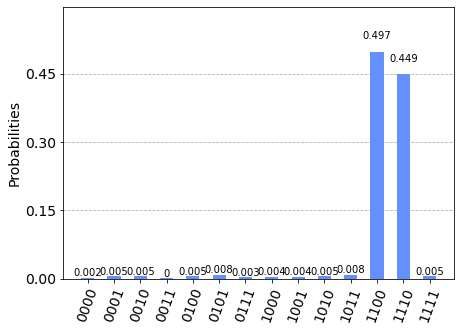

In [28]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)